In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score,precision_recall_curve,precision_score,confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import shap
shap.initjs()

In [4]:
sample_df=pd.read_csv('sampleEntry.csv')
print(sample_df)

            Id  Probability
0            1     0.080807
1            2     0.040719
2            3     0.011968
3            4     0.067640
4            5     0.108264
...        ...          ...
101498  101499     0.045363
101499  101500     0.343775
101500  101501     0.006970
101501  101502     0.121994
101502  101503     0.044248

[101503 rows x 2 columns]


In [5]:
column_df=pd.read_excel('Data Dictionary.xls',engine='xlrd')
column_df #basically giving us information about columns(features description)

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Variable Name,Description,Type
1,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
2,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
3,age,Age of borrower in years,integer
4,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
5,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer


In [6]:
#renaming the columns for easier understanding of its purpose
train_df=pd.read_csv('cs-training.csv')
train_df.drop(columns='Unnamed: 0',inplace=True)
train_df.rename(columns={'RevolvingUtilizationOfUnsecuredLines':'Credit_used'
                   ,'SeriousDlqin2yrs':'Target',
                  'NumberOfTime30-59DaysPastDueNotWorse':'Number_times_late_30_59_days'},inplace=True)
display(train_df)
train_df=train_df.drop_duplicates()

,Target,Credit_used,age,Number_times_late_30_59_days,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [7]:
print(train_df.info())# 2 columns Monthly income and No. of dependents has missing values
print(train_df.shape)
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 149391 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Target                                149391 non-null  int64  
 1   Credit_used                           149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   Number_times_late_30_59_days          149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtypes: fl

In [8]:
print(train_df['NumberOfDependents'].value_counts(normalize=True))
print(train_df['MonthlyIncome'].isna().mean())

NumberOfDependents
0.0     0.593502
1.0     0.180774
2.0     0.134107
3.0     0.065147
4.0     0.019662
5.0     0.005125
6.0     0.001085
7.0     0.000350
8.0     0.000165
10.0    0.000034
9.0     0.000034
20.0    0.000007
13.0    0.000007
Name: proportion, dtype: float64
0.1956008059387781


In [9]:
print(train_df['Target'].value_counts())
# very imbalanced almost 95 percent are non defaulters
print("check if missing income is related to target in some way")
print(train_df.groupby('Target')['MonthlyIncome'].apply(lambda x: x.isnull().mean()))
# so missing monthly income doesnt mean more likely to default

print("\n See if both are missing together:")
print(pd.crosstab(train_df['MonthlyIncome'].isnull(), 
                  train_df['NumberOfDependents'].isnull()))
# its a pattern where no of dependent is missing its sure to have monthly income  missing but not other way around

print("\n check if age is realted to missing income:")
print(train_df.groupby(train_df['MonthlyIncome'].isnull())['age'].describe())
#nothing much got here almost negligible age difference of 5-6 years 

print("\n check missing monthly income people debt ratio")
print(train_df.groupby(train_df['MonthlyIncome'].isnull())['DebtRatio'].median())
# well we got a surprise we could see that non missing had okay debt ration but for missing its shockicg
# its that those people that have debt didnt report missing income and system divided it by very small number or something generating garbage value

Target
0    139382
1     10009
Name: count, dtype: int64
check if missing income is related to target in some way
Target
0    0.197780
1    0.165251
Name: MonthlyIncome, dtype: float64

 See if both are missing together:
NumberOfDependents   False  True 
MonthlyIncome                    
False               120170      0
True                 25393   3828

 check if age is realted to missing income:
                  count       mean        std   min   25%   50%   75%    max
MonthlyIncome                                                               
False          120170.0  51.311966  14.410254   0.0  41.0  51.0  61.0  103.0
True            29221.0  56.395127  15.293975  21.0  46.0  57.0  67.0  109.0

 check missing monthly income people debt ratio
MonthlyIncome
False       0.296174
True     1198.000000
Name: DebtRatio, dtype: float64


In [10]:
print(train_df.describe())
# we can see the data is very messy(outliers,skewed) like age 109 and late 98 times and many more

              Target    Credit_used            age  \
count  149391.000000  149391.000000  149391.000000   
mean        0.066999       6.071087      52.306237   
std         0.250021     250.263672      14.725962   
min         0.000000       0.000000       0.000000   
25%         0.000000       0.030132      41.000000   
50%         0.000000       0.154235      52.000000   
75%         0.000000       0.556494      63.000000   
max         1.000000   50708.000000     109.000000   

       Number_times_late_30_59_days      DebtRatio  MonthlyIncome  \
count                 149391.000000  149391.000000   1.201700e+05   
mean                       0.393886     354.436740   6.675098e+03   
std                        3.852953    2041.843455   1.438958e+04   
min                        0.000000       0.000000   0.000000e+00   
25%                        0.000000       0.177441   3.400000e+03   
50%                        0.000000       0.368234   5.400000e+03   
75%                        0.0

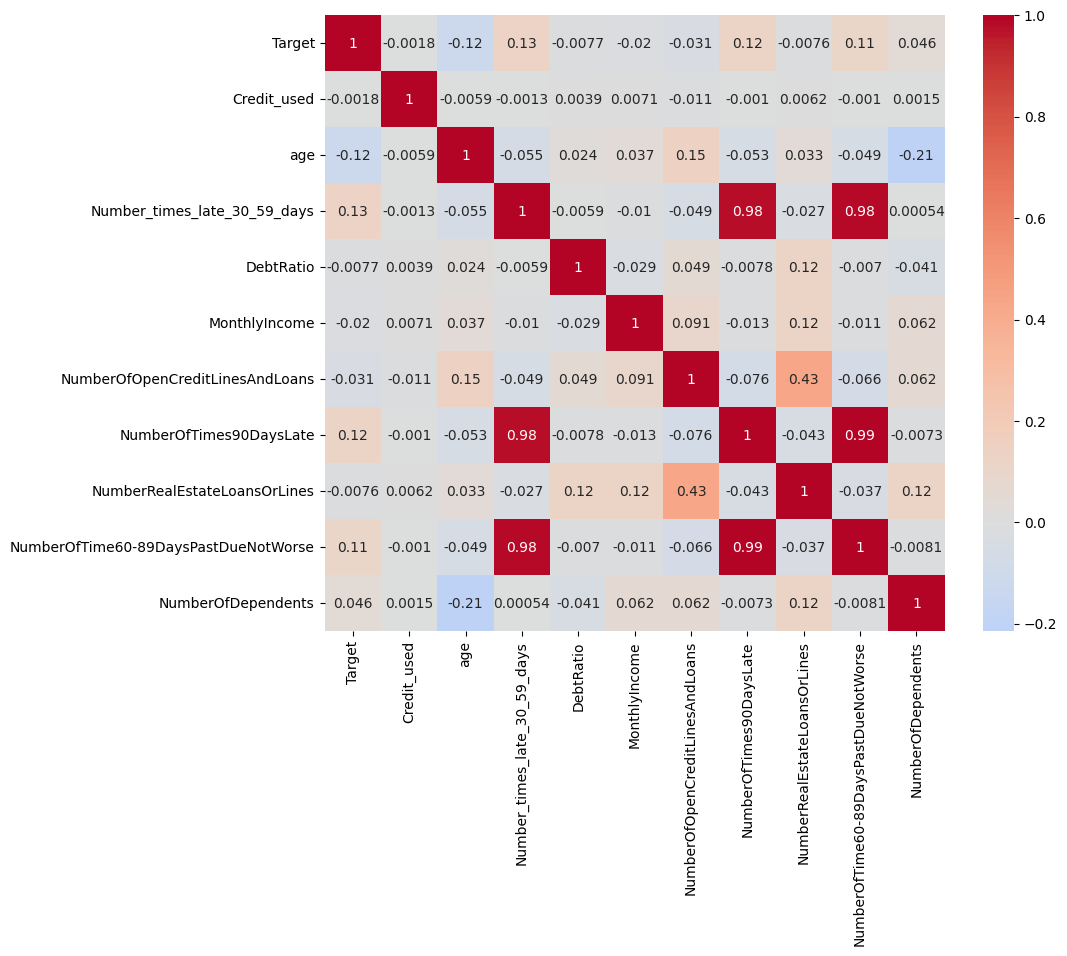

Number_times_late_30_59_days          NumberOfTimes90DaysLate                 0.980489
                                      NumberOfTime60-89DaysPastDueNotWorse    0.984535
NumberOfTimes90DaysLate               Number_times_late_30_59_days            0.980489
                                      NumberOfTime60-89DaysPastDueNotWorse    0.991409
NumberOfTime60-89DaysPastDueNotWorse  Number_times_late_30_59_days            0.984535
                                      NumberOfTimes90DaysLate                 0.991409
dtype: float64
Target                                  1.000000
Number_times_late_30_59_days            0.131517
NumberOfTimes90DaysLate                 0.122495
NumberOfTime60-89DaysPastDueNotWorse    0.106257
NumberOfDependents                      0.045786
Credit_used                            -0.001818
NumberRealEstateLoansOrLines           -0.007631
DebtRatio                              -0.007719
MonthlyIncome                          -0.019814
NumberOfOpenCreditLine

In [11]:
#checking multicollinearity
corr = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=True, cmap='coolwarm', center=0)
plt.show()
high_corr = corr[(corr > 0.8) & (corr < 1.0)].stack()
print(high_corr)
target_corr =train_df.corr()['Target'].sort_values(ascending=False)
print(target_corr)

In [12]:
# lets check for skewness of data to see what to fill in missing values
print(train_df.skew())

Target                                    3.463772
Credit_used                              97.433211
age                                       0.192258
Number_times_late_30_59_days             24.474608
DebtRatio                                94.979721
MonthlyIncome                           114.016565
NumberOfOpenCreditLinesAndLoans           1.221834
NumberOfTimes90DaysLate                  25.107372
NumberRealEstateLoansOrLines              3.484705
NumberOfTime60-89DaysPastDueNotWorse     25.424388
NumberOfDependents                        1.583308
dtype: float64


In [13]:
# now lets detect outliers so z_score wont work as the data is highly skewed so iqr
for col in train_df.columns:
    q_1=train_df[col].quantile(0.25)
    q_3=train_df[col].quantile(0.75)
    iqr=q_3-q_1
    lower_cap=q_1-(1.5*iqr)
    upper_cap=q_3+(1.5*iqr)
    outliers=(train_df[col]<lower_cap) | (train_df[col]>upper_cap)
    print(col,'=',outliers.sum())

Target = 10009
Credit_used = 769
age = 45
Number_times_late_30_59_days = 23938
DebtRatio = 31285
MonthlyIncome = 4878
NumberOfOpenCreditLinesAndLoans = 3980
NumberOfTimes90DaysLate = 8283
NumberRealEstateLoansOrLines = 793
NumberOfTime60-89DaysPastDueNotWorse = 7560
NumberOfDependents = 13336


In [14]:
X=train_df.drop('Target',axis=1)
y=train_df['Target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [15]:
print(X_train.head())

        Credit_used  age  Number_times_late_30_59_days    DebtRatio  \
33184      0.628651   65                             0  1827.000000   
106383     0.011567   80                             0     1.704319   
13756      0.131268   79                             0     0.343137   
72179      1.000000   27                             0     0.189684   
53116      0.115464   67                             0     0.360104   

        MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
33184             NaN                                9   
106383          300.0                               10   
13756          8363.0                                5   
72179          3605.0                                5   
53116          3062.0                               15   

        NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
33184                         0                             0   
106383                        0                             0   
13756                        

In [16]:
# Used only to show class imbalance and set the minimum performance baseline
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier(strategy='most_frequent')
model=dummy.fit(X_train,y_train)
y_predict = model.predict(X_test)
y_probability= model.predict_proba(X_test)[:, 1]
print(y_probability)
print(classification_report(y_test, y_predict,zero_division=0))
print(f"ROC-AUC: {roc_auc_score(y_test, y_probability):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_probability):.4f}")

[0. 0. 0. ... 0. 0. 0.]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     27877
           1       0.00      0.00      0.00      2002

    accuracy                           0.93     29879
   macro avg       0.47      0.50      0.48     29879
weighted avg       0.87      0.93      0.90     29879

ROC-AUC: 0.5000
PR-AUC: 0.0670


In [17]:
baselint_logistic=Pipeline([ 
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000)) ])
baselint_logistic.set_output(transform="pandas")
baselint_logistic.fit(X_train,y_train)
y_predict = baselint_logistic.predict(X_test)
y_probability= baselint_logistic.predict_proba(X_test)[:, 1]
print(y_probability)
print(classification_report(y_test, y_predict))
print(f"ROC-AUC: {roc_auc_score(y_test, y_probability):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_probability):.4f}")

[0.02416945 0.16134668 0.02943526 ... 0.0858902  0.05020689 0.04624807]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27877
           1       0.51      0.04      0.07      2002

    accuracy                           0.93     29879
   macro avg       0.72      0.52      0.52     29879
weighted avg       0.91      0.93      0.91     29879

ROC-AUC: 0.6990
PR-AUC: 0.2250


In [18]:
from sklearn.impute import SimpleImputer
#function to flag missing values and fix debt ratio
def fix_debt_ratio(df):
    df=df.copy()
    df['Monthly_income_missing']=df['MonthlyIncome'].isnull().astype(int)
    df['Num_dependent_missing']=df['NumberOfDependents'].isnull().astype(int)
    debt_median=df.loc[df['MonthlyIncome'].notnull(),'DebtRatio'].median()
    df.loc[df['Monthly_income_missing']==1,'DebtRatio']=debt_median
    return df

In [19]:
fix_debt=FunctionTransformer(fix_debt_ratio)

In [20]:
def add_advanced_late_features(df):
    d30 = df["Number_times_late_30_59_days"]
    d60 = df["NumberOfTime60-89DaysPastDueNotWorse"]
    d90 = df["NumberOfTimes90DaysLate"]

    df["Total_Late_Events"] = d30 + d60 + d90
    
    df["Severity_Score"] = 1*d30 + 2*d60 + 3*d90
    
    df["Any_Severe_Late"] = (d60 + d90 > 0).astype(int)

    return df
tuned_late_features=FunctionTransformer(add_advanced_late_features)

In [21]:
#using capping/winsorizing to keep useful data and handle outliers effectively for skewed data
def clip_outliers_iqr(df):
    df=df.copy()
    col_cap_iqr=['Credit_used','age', 'DebtRatio',
           'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'
                 , 'NumberRealEstateLoansOrLines', 'NumberOfDependents']
    for col in col_cap_iqr:
        q_1=df[col].quantile(0.25)
        q_3=df[col].quantile(0.75)
        iqr=q_3-q_1
        lower_cap=q_1-(1.5*iqr)
        upper_cap=q_3+(1.5*iqr)
        df[col]=df[col].clip(lower_cap,upper_cap)
    return df
fix_outliers_iqr=FunctionTransformer(clip_outliers_iqr)

In [22]:
#you see we didnt you iqr cap method on late time columns as they are mostly zero and using iqr would convert all to 0
def clip_outliers_late(df):
    df=df.copy()
    col_to_cap=["NumberOfTimes90DaysLate","Number_times_late_30_59_days","NumberOfTime60-89DaysPastDueNotWorse",
               "Total_Late_Events","Severity_Score","Any_Severe_Late"]
    for col in col_to_cap:
        lower_cap=df[col].quantile(0)
        upper_cap=df[col].quantile(0.99)
        df[col]=df[col].clip(lower_cap,upper_cap)
    return df 
fix_outliers_late_col=FunctionTransformer(clip_outliers_late)

In [23]:
debt_col=['MonthlyIncome','NumberOfDependents','DebtRatio']
late_col_for=["NumberOfTimes90DaysLate","Number_times_late_30_59_days","NumberOfTime60-89DaysPastDueNotWorse"]

fixing_debtratio=ColumnTransformer(
    transformers=[('fix_the_debt',fix_debt,debt_col),
                  ('new_late_features',tuned_late_features,late_col_for)
                 ],remainder='passthrough',verbose_feature_names_out=False)

filling_missing_values=ColumnTransformer(
    transformers=[
        ('median_impute',SimpleImputer(strategy='median'),['MonthlyIncome']),
        ('mode_impute',SimpleImputer(strategy='most_frequent'),['NumberOfDependents'])
    ],remainder='passthrough',verbose_feature_names_out=False
)
col_cap_iqr=['Credit_used','age', 'DebtRatio',
           'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'
                 , 'NumberRealEstateLoansOrLines', 'NumberOfDependents']

col_to_cap=["NumberOfTimes90DaysLate","Number_times_late_30_59_days","NumberOfTime60-89DaysPastDueNotWorse",
               "Total_Late_Events","Severity_Score","Any_Severe_Late"]
cap_outlier=ColumnTransformer(
    transformers=[
        ('iqr_used',fix_outliers_iqr,col_cap_iqr),
        ('percentile',fix_outliers_late_col,col_to_cap)],
        remainder='passthrough',verbose_feature_names_out=False)


        
col_skew_sqrt=['DebtRatio','Credit_used','NumberRealEstateLoansOrLines','MonthlyIncome']
correct_skew=ColumnTransformer(
    transformers=[
        ('sqrt',FunctionTransformer(np.sqrt),col_skew_sqrt),
        ('yeo',PowerTransformer(method='yeo-johnson'),col_to_cap)
    ],remainder='passthrough',verbose_feature_names_out=False
)

pipeline_lg=Pipeline([
    ('fixdebt',fixing_debtratio),
    ('impute',filling_missing_values),
    ('fix_outlierr',cap_outlier),
    ('skewed_data',correct_skew),
    ('scaler',StandardScaler()),
    ('model',LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced'))
])

pipeline_xgb = Pipeline([
    ('fixdebt', fixing_debtratio),
    ('impute', filling_missing_values),
    ('fix_outlierr', cap_outlier),
    ('model', XGBClassifier(n_estimators=100,max_depth=6,learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), 
        random_state=42,
        eval_metric='logloss'
    ))
])
pipeline_lgb = Pipeline([
    ('fixdebt', fixing_debtratio),
    ('impute', filling_missing_values),
    ('fix_outlierr', cap_outlier),
    ('model', LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        verbose=-1
    ))
])
pipeline_lg.set_output(transform="pandas")
pipeline_lg.fit(X_train,y_train)
pipeline_xgb.set_output(transform="pandas")
pipeline_xgb.fit(X_train,y_train)
pipeline_lgb.set_output(transform="pandas")
pipeline_lgb.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('fixdebt', ...), ('impute', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('fix_the_debt', ...), ('new_late_features', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output o

In [24]:
fitted_models = {
    'LogisticReg':pipeline_lg,
    'XGBoostModel': pipeline_xgb,
    'Lightgb':pipeline_lgb
}

for name, model in fitted_models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print('='*50)
    y_pred = model.predict(X_test)
    y_proba= model.predict_proba(X_test)[:, 1]
    print(y_proba)
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")
    
    # For imbalanced data, use StratifiedKFold 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf,scoring='roc_auc') 
    
    print(f"CV ROC-AUC scores: {cv_scores}")
    print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Model: LogisticReg
[0.05961627 0.75678063 0.07808456 ... 0.29393356 0.1266815  0.51223788]
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     27877
           1       0.22      0.76      0.34      2002

    accuracy                           0.80     29879
   macro avg       0.60      0.78      0.61     29879
weighted avg       0.93      0.80      0.85     29879

ROC-AUC: 0.8548
PR-AUC: 0.3735
CV ROC-AUC scores: [0.85411375 0.85539917 0.85324259 0.85592717 0.85623281]
Mean: 0.8550 (+/- 0.0011)

Model: XGBoostModel
[0.02025973 0.67682666 0.04717484 ... 0.16979666 0.10778323 0.58793986]
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     27877
           1       0.23      0.77      0.35      2002

    accuracy                           0.81     29879
   macro avg       0.60      0.79      0.62     29879
weighted avg       0.93      0.81      0.85     29879

ROC-AUC: 0.8627
PR-AUC: 0.39

In [27]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
}
grid_search = GridSearchCV(
    pipeline_lg, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model_lg = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best CV score: {best_score}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'model__C': 100}
Best CV score: 0.8549751536710888


In [28]:
class_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

param_dist = {
    "model__n_estimators": randint(200, 1000),           
    "model__max_depth": randint(3, 12),                  
    "model__learning_rate": uniform(0.01, 0.19),         
    "model__subsample": uniform(0.6, 0.4),      
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__min_child_weight": randint(1, 10),
    "model__scale_pos_weight": uniform(class_ratio * 0.5, class_ratio),
    "model__reg_alpha": uniform(0, 5),                   
    "model__reg_lambda": uniform(1, 5)                  
}
random_search = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist,
    n_iter=100,                                         
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best ROC-AUC:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'model__colsample_bytree': np.float64(0.798070764044508), 'model__learning_rate': np.float64(0.016533819011891496), 'model__max_depth': 3, 'model__min_child_weight': 4, 'model__n_estimators': 761, 'model__reg_alpha': np.float64(3.31261142176991), 'model__reg_lambda': np.float64(2.558555380447055), 'model__scale_pos_weight': np.float64(14.205405857553615), 'model__subsample': np.float64(0.8186841117373118)}
Best ROC-AUC: 0.8664920872232035


In [23]:
class_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
param_dist_lgb = {
    "model__n_estimators": randint(200, 1000),
    "model__max_depth": randint(3, 12),
    "model__learning_rate": uniform(0.01, 0.19),
    "model__subsample": uniform(0.6, 0.4),              
    "model__colsample_bytree": uniform(0.6, 0.4),     
    "model__min_child_weight": uniform(0.001, 0.1),    
    "model__scale_pos_weight": uniform(class_ratio * 0.5, class_ratio),
    "model__reg_alpha": uniform(0, 5),
    "model__reg_lambda": uniform(1, 5),
    "model__num_leaves": randint(20, 100)         
}
random_search_lgb = RandomizedSearchCV(
    pipeline_lgb,
    param_distributions=param_dist_lgb,
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)
random_search_lgb.fit(X_train, y_train)
print("Best params:", random_search_lgb.best_params_)
print("Best ROC-AUC:", random_search_lgb.best_score_)
best_model = random_search_lgb.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'model__colsample_bytree': np.float64(0.8046628054189044), 'model__learning_rate': np.float64(0.03982575971607681), 'model__max_depth': 3, 'model__min_child_weight': np.float64(0.028687764814720376), 'model__n_estimators': 456, 'model__num_leaves': 27, 'model__reg_alpha': np.float64(3.7412984519182917), 'model__reg_lambda': np.float64(1.9226050967818866), 'model__scale_pos_weight': np.float64(9.878355975853614), 'model__subsample': np.float64(0.7481888411165528)}
Best ROC-AUC: 0.8665664143510566


In [30]:
# Tried random forest base and tuned model but logistic still beat them in recall (41% vs LogReg's 77%)
pipeline_rf=Pipeline([
    ('fixdebt',fixing_debtratio),
    ('impute',filling_missing_values),
    ('fix_outlierr',cap_outlier),
    ('model',RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'))
])
pipeline_rft = Pipeline([
   ('fixdebt', fixing_debtratio),
    ('impute', filling_missing_values),
    ('fix_outlierr', cap_outlier),
    ('model', RandomForestClassifier(n_estimators=600,max_depth=None,min_samples_split=10,min_samples_leaf=4,
        max_features='sqrt',bootstrap=True,class_weight='balanced_subsample',random_state=42,n_jobs=-1))
])
pipeline_rf.set_output(transform="pandas")
pipeline_rf.fit(X_train,y_train)
pipeline_rft.set_output(transform="pandas")
pipeline_rft.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('fixdebt', ...), ('impute', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('fix_the_debt', ...), ('new_late_features', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output o

In [31]:
fitted_models = {
    'randomforest_base':pipeline_rf,
    'random_forest_tuned': pipeline_rft
}

for name, model in fitted_models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print('='*50)
    y_pred = model.predict(X_test)
    y_proba= model.predict_proba(X_test)[:, 1]
    print(y_proba)
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")
    
    # For imbalanced data, use StratifiedKFold 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf,scoring='roc_auc') 
    
    print(f"CV ROC-AUC scores: {cv_scores}")
    print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Model: randomforest_base
[0.   0.02 0.01 ... 0.01 0.01 0.09]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27877
           1       0.55      0.18      0.27      2002

    accuracy                           0.94     29879
   macro avg       0.75      0.59      0.62     29879
weighted avg       0.92      0.94      0.92     29879

ROC-AUC: 0.8316
PR-AUC: 0.3496
CV ROC-AUC scores: [0.827332   0.83409721 0.83219027 0.83737067 0.82944743]
Mean: 0.8321 (+/- 0.0035)

Model: random_forest_tuned
[0.01255569 0.25556108 0.03251425 ... 0.0650672  0.02250557 0.2349523 ]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27877
           1       0.39      0.52      0.44      2002

    accuracy                           0.91     29879
   macro avg       0.68      0.73      0.70     29879
weighted avg       0.93      0.91      0.92     29879

ROC-AUC: 0.8561
PR-AUC: 0.3864
CV ROC-AUC scores: [

In [32]:
#stacking ensemble method
from sklearn.ensemble import StackingClassifier
stacking_ensemble = StackingClassifier(
    estimators=[
        ('lgb', pipeline_lgb),
        ('rft', pipeline_rft)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,
    passthrough=False  # Only using predictions from base models
)

stacking_ensemble.fit(X_train, y_train)

y_proba_stacking = stacking_ensemble.predict_proba(X_test)[:, 1]
y_pred_stacking = stacking_ensemble.predict(X_test)

print("="*50)
print("STACKING ENSEMBLE")
print("="*50)
print(classification_report(y_test, y_pred_stacking))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_stacking):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba_stacking):.4f}")

STACKING ENSEMBLE
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27877
           1       0.22      0.79      0.34      2002

    accuracy                           0.79     29879
   macro avg       0.60      0.79      0.61     29879
weighted avg       0.93      0.79      0.84     29879

ROC-AUC: 0.8633
PR-AUC: 0.4027


 99%|===================| 29647/29879 [01:56<00:00]        

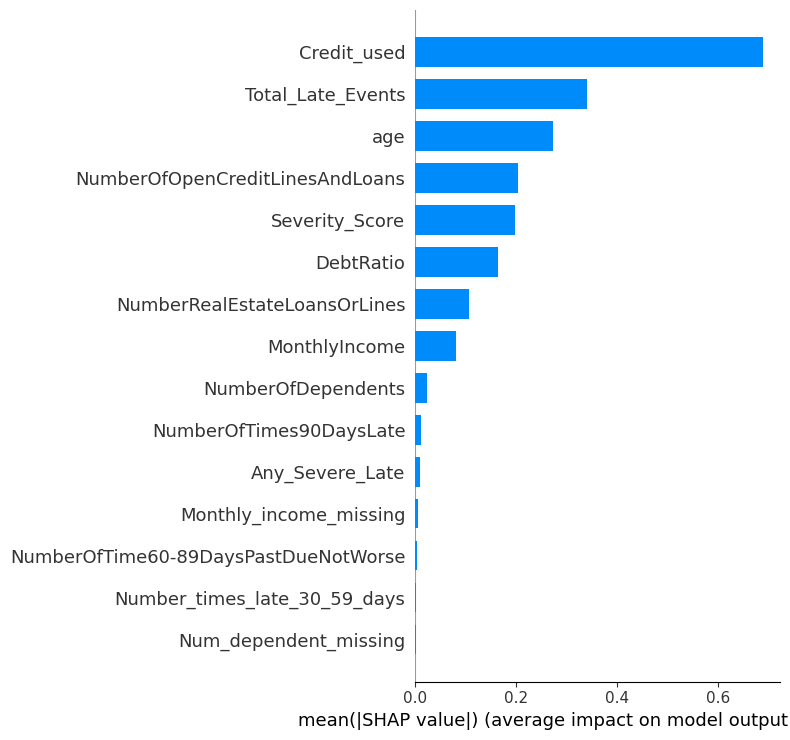

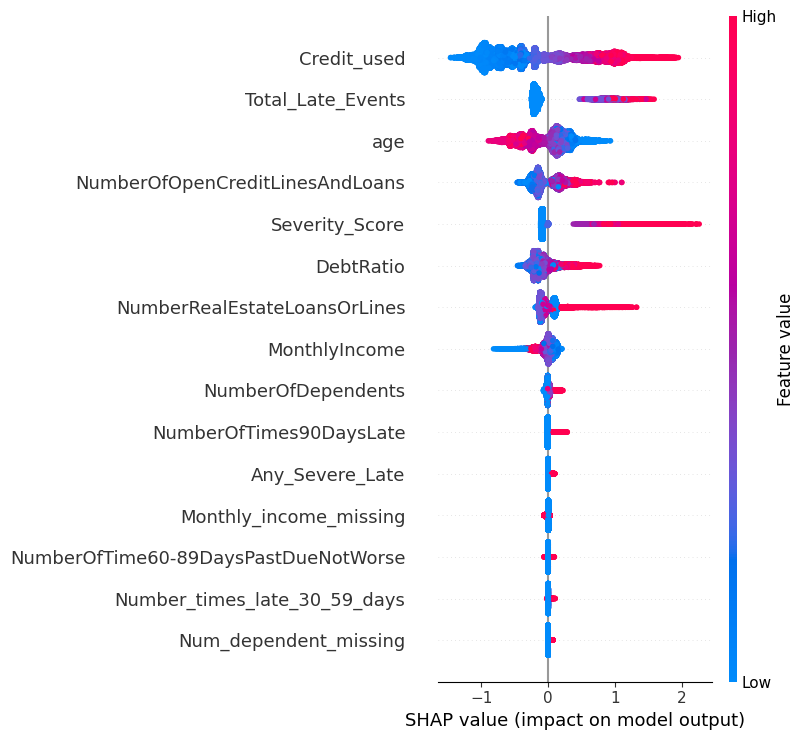

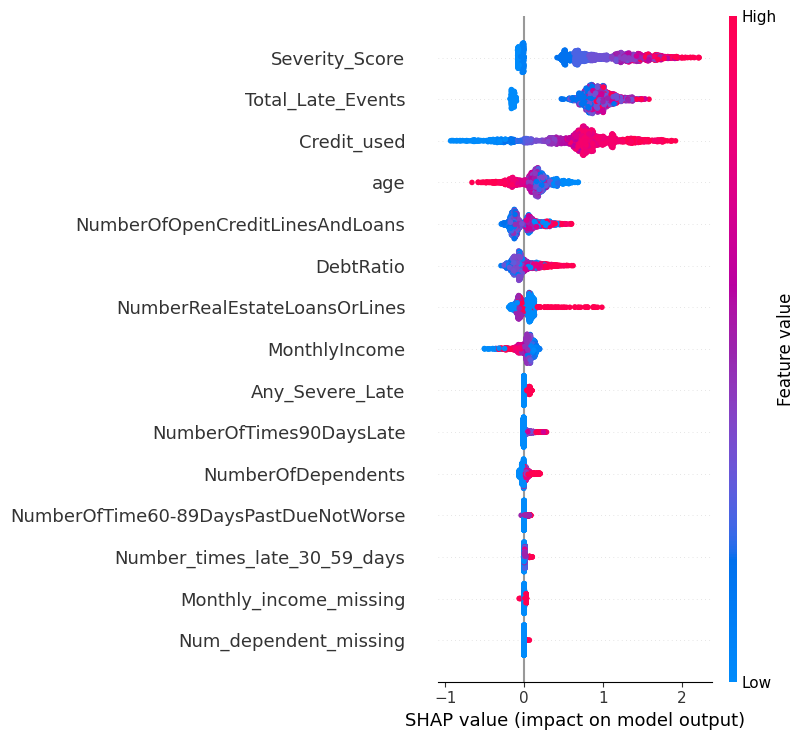

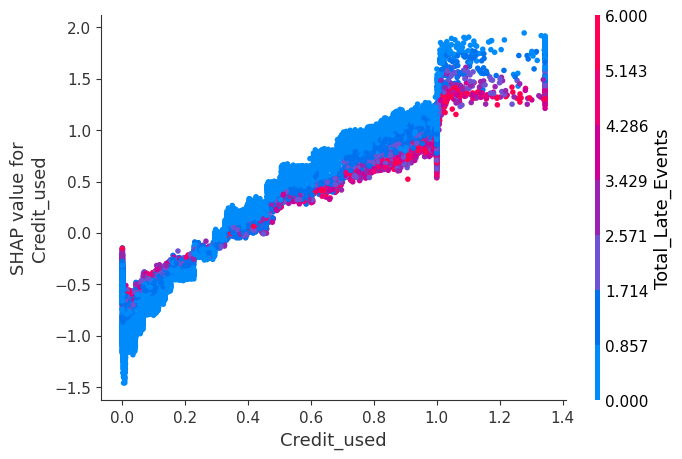

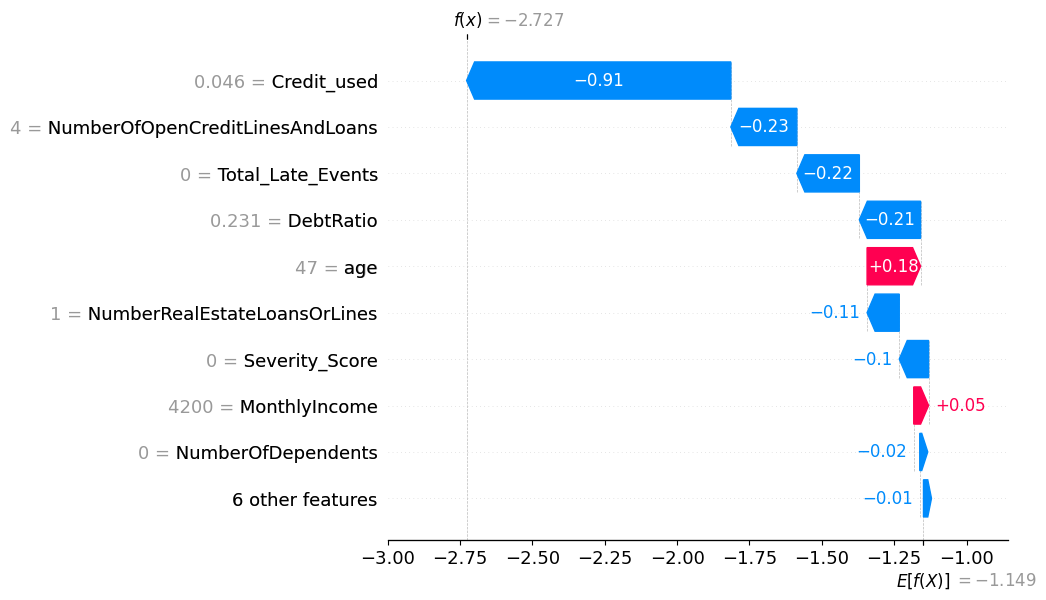

In [35]:
# Extract the preprocessed test data
X_test_transformed = best_model[:-1].transform(X_test)

# Get trained LightGBM model
lgb_model = best_model.named_steps['model']

explainer = shap.Explainer(lgb_model, X_test_transformed)
shap_values = explainer(X_test_transformed)

# 1. Summary bar plot
shap.summary_plot(shap_values.values, X_test_transformed, plot_type="bar")

# 2. Beeswarm plot
shap.summary_plot(shap_values.values, X_test_transformed)

# 3. False positive analysis
fp_mask = (y_pred == 1) & (y_test == 0)
fp_indices = np.where(fp_mask)[0]

shap.summary_plot(
    shap_values.values[fp_indices],
    X_test_transformed.iloc[fp_indices]  
)

# 4. Dependence plot
shap.dependence_plot(
    "Credit_used",
    shap_values.values,
    X_test_transformed
)

# 5. Waterfall plot (single sample)
sample_idx = 5
shap.plots.waterfall(shap_values[sample_idx])
# SHAP insights:
# Credit utilization is the strongest driver of default risk with a clear monotonic effect.
# Late payment behavior contributes substantial nonlinear risk, increasing with severity.
# Age shows a protective relationship, with higher age associated with lower predicted risk.
# DebtRatio impacts risk primarily at extreme values.
# Model reliance is concentrated in a small set of core features, supporting interpretability.

# Business action: Prioritize review for high utilization accounts with any history of late payments.



In [24]:
cal_pipeline_lgb = CalibratedClassifierCV(best_model, cv=5, method='isotonic')
cal_pipeline_lgb.fit(X_train, y_train)

print(f"\n{'='*50}")
print(f"Model: {'Lightgbm'}")
print('='*50)
y_pred = cal_pipeline_lgb.predict(X_test)
y_proba= cal_pipeline_lgb.predict_proba(X_test)[:, 1]
print(y_proba)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(cal_pipeline_lgb, X_train, y_train, cv=skf,scoring='roc_auc') 

print(f"CV ROC-AUC scores: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Model: Lightgbm
[0.0019898  0.23597208 0.00247761 ... 0.01853353 0.00938401 0.10360894]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27877
           1       0.61      0.19      0.29      2002

    accuracy                           0.94     29879
   macro avg       0.78      0.59      0.63     29879
weighted avg       0.92      0.94      0.92     29879

ROC-AUC: 0.8650
PR-AUC: 0.4084
CV ROC-AUC scores: [0.86380658 0.86602521 0.86650826 0.86951258 0.86436318]
Mean: 0.8660 (+/- 0.0020)


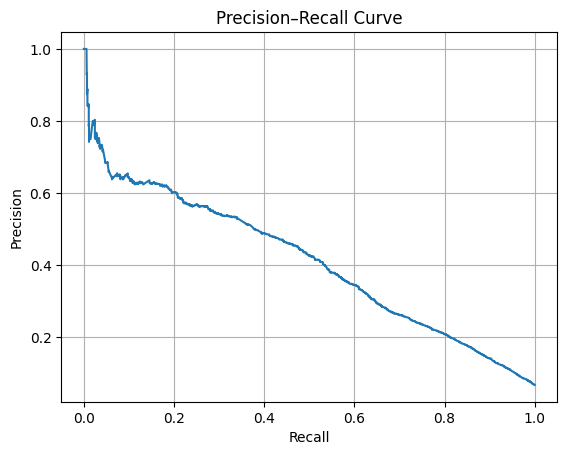

Best threshold (recall≥0.75): 0.08379084473073863
              precision    recall  f1-score   support

           0       0.98      0.82      0.90     27877
           1       0.24      0.75      0.36      2002

    accuracy                           0.82     29879
   macro avg       0.61      0.79      0.63     29879
weighted avg       0.93      0.82      0.86     29879



In [25]:
y_proba = cal_pipeline_lgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid()
plt.show()
mask = recall[:-1] >= 0.75                   
best_idx = np.argmax(precision[:-1][mask])       
best_threshold = thresholds[mask][best_idx]

print("Best threshold (recall≥0.75):", best_threshold)

# apply threshold
y_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_custom))

Optimal cost-based threshold: 0.020
Minimum total cost: $2,070,000


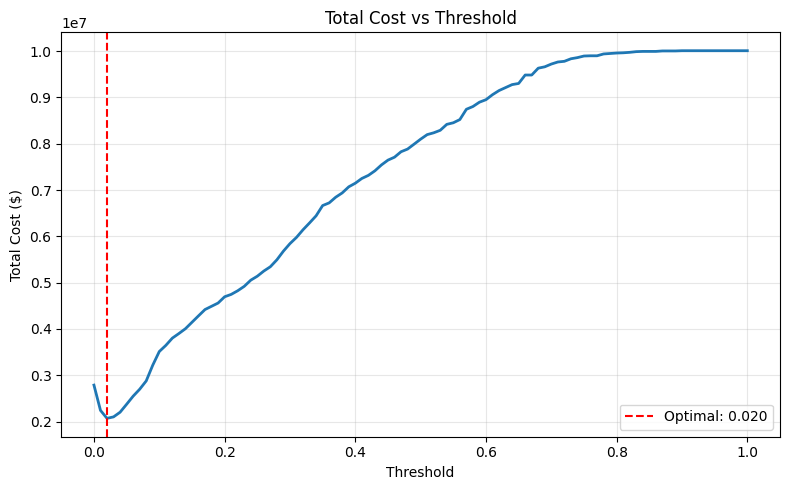


Classification Report (Cost-Optimized):
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     27877
           1       0.12      0.93      0.21      2002

    accuracy                           0.53     29879
   macro avg       0.55      0.72      0.44     29879
weighted avg       0.93      0.53      0.63     29879


Cost Breakdown:
False Positives: 13950 × $100 = $1,395,000
False Negatives: 135 × $5000 = $675,000
Total Cost: $2,070,000


In [26]:
cost_fp = 100      # Cost of manual review/lost customer
cost_fn = 5000     # Average loan loss when default is missed

y_proba = cal_pipeline_lgb.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 101)

# Compute cost for each threshold
total_costs = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    fp = np.sum((y_pred == 1) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    total_costs.append(fp * cost_fp + fn * cost_fn)

# Find optimal threshold
best_idx = np.argmin(total_costs)
best_threshold = thresholds[best_idx]

print(f"Optimal cost-based threshold: {best_threshold:.3f}")
print(f"Minimum total cost: ${min(total_costs):,.0f}")

# Visualize cost curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, total_costs, linewidth=2)
plt.axvline(best_threshold, color='r', linestyle='--', 
            label=f'Optimal: {best_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Total Cost vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cost_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Apply optimal threshold and show results
y_opt = (y_proba >= best_threshold).astype(int)
print("\nClassification Report (Cost-Optimized):")
print(classification_report(y_test, y_opt))

# Cost breakdown
cm = confusion_matrix(y_test, y_opt)
print(f"\nCost Breakdown:")
print(f"False Positives: {cm[0,1]} × ${cost_fp} = ${cm[0,1]*cost_fp:,.0f}")
print(f"False Negatives: {cm[1,0]} × ${cost_fn} = ${cm[1,0]*cost_fn:,.0f}")
print(f"Total Cost: ${cm[0,1]*cost_fp + cm[1,0]*cost_fn:,.0f}")
#if average loan is $10K
#prevented losses by catching defaulters is $18.6M
#Cost to achieve this is $2.07M
#Net benefit is $16.5M
#ROI = 800% ($16.6M profit / $2.07M cost)

In [42]:
joblib.dump(cal_pipeline_lgb, 'credit_model_final.pkl')
config = {
    'threshold': best_threshold,
    'best_params': random_search_lgb.best_params_,
    'best_roc_auc': random_search_lgb.best_score_
}
joblib.dump(config, 'model_config.pkl')

['model_config.pkl']

In [25]:
# Test loading
loaded_model = joblib.load('credit_model_final.pkl')
loaded_config = joblib.load('model_config.pkl')

# Test prediction
y_proba_test = loaded_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= loaded_config['threshold']).astype(int)

print("Model loaded successfully!")
print(f"Threshold: {loaded_config['threshold']}")
print(classification_report(y_test, y_pred_test))

Model loaded successfully!
Threshold: 0.02
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     27877
           1       0.12      0.93      0.21      2002

    accuracy                           0.53     29879
   macro avg       0.55      0.72      0.44     29879
weighted avg       0.93      0.53      0.63     29879



In [38]:
error_df = X_test.copy()
error_df["y_true"] = y_test.values
error_df["y_pred_test"] = y_pred_test
error_df["y_proba_test"] = y_proba_test
fp = error_df[(error_df.y_true == 0) & (error_df.y_pred_test == 1)]
fn = error_df[(error_df.y_true == 1) & (error_df.y_pred_test == 0)]
tp = error_df[(error_df.y_true == 1) & (error_df.y_pred_test == 1)]
tn = error_df[(error_df.y_true == 0) & (error_df.y_pred_test == 0)]

In [39]:
print(X_test.columns)

Index(['Credit_used', 'age', 'Number_times_late_30_59_days', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'],
      dtype='object')


In [42]:
print("=== Credit_used (0-1 scale, clean) ===")
print(f"FN median: {fn['Credit_used'].median():.3f}")
print(f"TP median: {tp['Credit_used'].median():.3f}")

print("\n=== Age (years, clean) ===")
print(f"FN median: {fn['age'].median():.0f}")
print(f"TP median: {tp['age'].median():.0f}")

print("\n=== MonthlyIncome (has missing, use only non-null) ===")
fn_income = fn['MonthlyIncome'].dropna()
tp_income = tp['MonthlyIncome'].dropna()
print(f"FN median: ${fn_income.median():.0f}")
print(f"TP median: ${tp_income.median():.0f}")
print(f"FN missing %: {fn['MonthlyIncome'].isna().mean()*100:.1f}%")

print("\n=== DebtRatio (MESSY - filter outliers for comparison) ===")
fn_debt = fn[fn['DebtRatio'] <= 1]['DebtRatio']  # Only reasonable values
tp_debt = tp[tp['DebtRatio'] <= 1]['DebtRatio']
print(f"FN median (filtered): {fn_debt.median():.3f}")
print(f"TP median (filtered): {tp_debt.median():.3f}")
print(f"FN with DebtRatio>1: {(fn['DebtRatio'] > 1).sum()} (GARBAGE DATA)")

print("\n=== NumberOfOpenCreditLinesAndLoans (counts, clean) ===")
print(f"FN median: {fn['NumberOfOpenCreditLinesAndLoans'].median():.0f}")
print(f"TP median: {tp['NumberOfOpenCreditLinesAndLoans'].median():.0f}")

print("\n=== Late Payment Features (counts, clean) ===")
print(f"90Days Late - FN: {fn['NumberOfTimes90DaysLate'].median():.0f}, TP: {tp['NumberOfTimes90DaysLate'].median():.0f}")
print(f"30-59Days Late - FN: {fn['Number_times_late_30_59_days'].median():.0f}, TP: {tp['Number_times_late_30_59_days'].median():.0f}")

#Probability analysis 
print(f"\n=== Threshold Issue? ===")
print(f"FN avg probability: {fn['y_proba_test'].mean():.3f}")
print(f"FP avg probability: {fp['y_proba_test'].mean():.3f}")

# Costs
print(f"\n=== Business Cost ===")
print(f"FN cost: ${len(fn) * 10000:,}")
print(f"FP cost: ${len(fp) * 500:,}")
# Errors are concentrated in a specific customer segment rather than being random.
# This confirms the model is working as designed and points to clear improvement directions.

=== Credit_used (0-1 scale, clean) ===
FN median: 0.049
TP median: 0.887

=== Age (years, clean) ===
FN median: 57
TP median: 45

=== MonthlyIncome (has missing, use only non-null) ===
FN median: $5000
TP median: $4220
FN missing %: 20.0%

=== DebtRatio (MESSY - filter outliers for comparison) ===
FN median (filtered): 0.255
TP median (filtered): 0.333
FN with DebtRatio>1: 29 (GARBAGE DATA)

=== NumberOfOpenCreditLinesAndLoans (counts, clean) ===
FN median: 8
TP median: 7

=== Late Payment Features (counts, clean) ===
90Days Late - FN: 0, TP: 0
30-59Days Late - FN: 0, TP: 1

=== Threshold Issue? ===
FN avg probability: 0.010
FP avg probability: 0.099

=== Business Cost ===
FN cost: $1,350,000
FP cost: $6,975,000


In [44]:
# Final summary
print("=== ERROR ANALYSIS SUMMARY ===")
print(f"Total test samples: {len(error_df)}")
print(f"True Positives: {len(tp)} | True Negatives: {len(tn)}")
print(f"False Positives: {len(fp)} | False Negatives: {len(fn)}")
print(f"\nOptimized Threshold: 0.020")
print(f"Total Business Cost: ${(len(fn)*5000 + len(fp)*100):,}")
print(f"\nKey Blind Spot: Older borrowers (age 57) with low credit usage (5%) and clean history")
print(f"Recommendation: Add interaction feature for low_usage × older_age segment")

=== ERROR ANALYSIS SUMMARY ===
Total test samples: 29879
True Positives: 1867 | True Negatives: 13927
False Positives: 13950 | False Negatives: 135

Optimized Threshold: 0.020
Total Business Cost: $2,070,000

Key Blind Spot: Older borrowers (age 57) with low credit usage (5%) and clean history
Recommendation: Add interaction feature for low_usage × older_age segment
